In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm

### Data Generation
Let's generate data with the following likelihood and see if our model can properly estimate model parameters with the data.<br>
Likelihood:
$$
p(y_i|x_i, \beta_0, \beta_1, \sigma) = \mathcal{N}\left(y_i| \hat{y}_i, \sigma^2\right)
$$
where
$$
\begin{aligned}
&\hat{y}=f(x; \beta_0, \beta_1) = \beta_0 + \beta_1 \times x_{1}\\
&\beta_0=-0.5\\
&\beta_1=1.5\\
&\sigma=0.85
\end{aligned}
$$

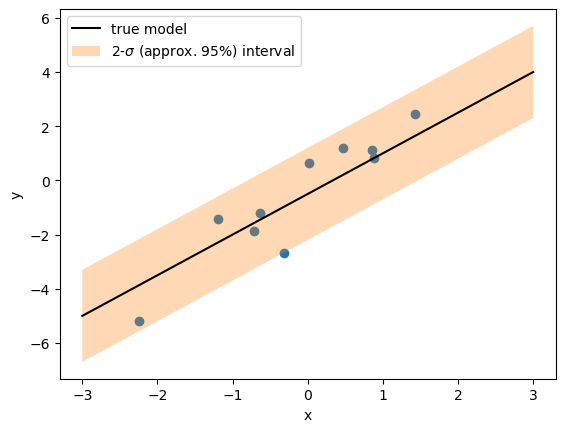

In [2]:
np.random.seed(1234) # for reproducibility

n = 10 # number of samples (datapoints)

beta0 = -0.5
beta1 = 1.5
sigma = 0.85

x = np.random.randn(n)  # input
y = beta0 + beta1*x + np.random.randn(n) * sigma

x_plot_true = np.linspace(-3,3,100) # points for visualization
y_plot_true = beta0 + beta1*x_plot_true # points for visualization

plt.scatter(x,y)
plt.plot(x_plot_true,y_plot_true,'k', label='true model')
plt.fill_between(x_plot_true, y_plot_true + 2*sigma, y_plot_true - 2*sigma, alpha=0.3, label='2-$\\sigma$ (approx. 95%) interval')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Construct a model and estimate model parameters
We assume that we do not know $\beta_0, \beta_1, \sigma$, and we don't have any prior knowledge. So, we use a very flat prior:
$$
\begin{aligned}
& p(\boldsymbol{\uptheta}) := p(\beta_0) p(\beta_1) p(\sigma) \\\\
& p(\beta_0) := \mathcal{N}(\beta_0|0,100) \\\\
& p(\beta_1) := \mathcal{N}(\beta_1|0,100) \\\\
& p(\sigma) := \text{Exp}(\sigma|1/100)
\end{aligned}
$$

We use the [[**PyMC package**]](https://www.pymc.io/welcome.html) for Bayesian modelling.

The cell below shows how to construct the model with PyMC. You will find that the lines within **model** are aligned with the likelihood and prior above. <br>
By running the cell below, we get 3000 samples from [[**Markov chain Monte Carlo (MCMC)**]](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) chains. The distribution of the samples approximates the posterior distribution $p(\beta_0, \beta_1, \sigma|\mathbf{x},\mathbf{y})$.

In [3]:
# model construction
model = pm.Model()
with model: # model specifications in PyMC3 are wrapped in a with-statement
    # prior (very flat distributions)
    t_beta0 = pm.Normal('beta0', mu=0., sigma=10.)
    t_beta1 = pm.Normal('beta1', mu=0., sigma=10.)
    t_sigma = pm.Exponential('sigma', lam=1/100) # because standard deviation should be a positive value,
                                               # we use exponential distribution instead.

    y_hat = t_beta0 + t_beta1*x

    # likelihood
    y_obs = pm.Normal('y_obs', mu=y_hat, sigma=t_sigma, observed=y)

# inference
with model:
    samples = pm.sample(3000) # The default inference algorithm is NUTS sampling (https://arxiv.org/abs/1111.4246).
                            # This is much more efficient than Metropolis–Hastings

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, sigma]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 68 seconds.


### Visualize modelling results

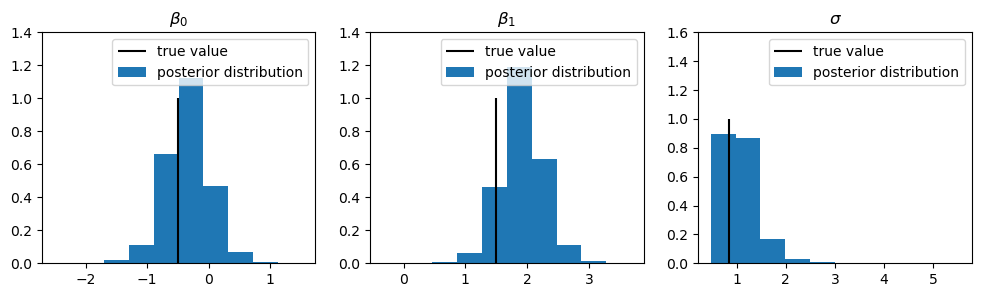

In [7]:
fig,ax = plt.subplots(1,3,figsize=(12,3))

ax[0].vlines(beta0,0,1,color='k')
ax[0].hist(samples.posterior['beta0'].values.reshape(-1,1),density=True)
ax[0].set_title('$\\beta_0$')
ax[0].legend(['true value', 'posterior distribution'])
ax[0].set_ylim(0,1.4)

ax[1].vlines(beta1,0,1,color='k')
ax[1].hist(samples.posterior['beta1'].values.reshape(-1,1),density=True)
ax[1].set_title('$\\beta_1$')
ax[1].legend(['true value', 'posterior distribution'])
ax[1].set_ylim(0,1.4)

ax[2].vlines(sigma,0,1,color='k')
ax[2].hist(samples.posterior['sigma'].values.reshape(-1,1),density=True)
ax[2].set_title('$\\sigma$')
ax[2].legend(['true value', 'posterior distribution'])
ax[2].set_ylim(0,1.6)

plt.show()

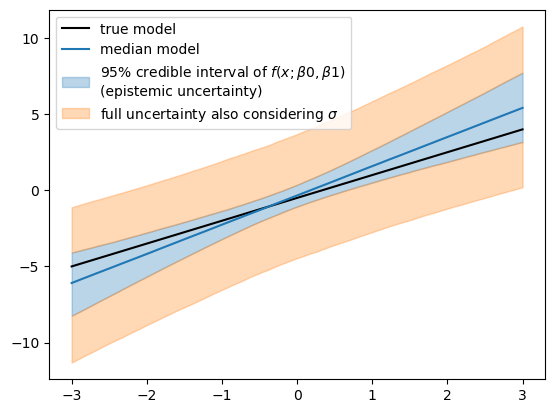

In [14]:
npost = samples.posterior['beta0'].values.flatten().shape[0] # number of posterior samples

x_plot = np.linspace(-3,3,100) # points for visualization
y_plot = np.empty((npost, 3, 100)) # points for visualization

trace_beta0 = samples.posterior['beta0'].values.flatten()
trace_beta1 = samples.posterior['beta1'].values.flatten()
trace_sigma = samples.posterior['sigma'].values.flatten()

for i in range(npost):
    y_plot[i,0,:] = trace_beta0[i] + trace_beta1[i]*x_plot - 2*trace_sigma[i]
    y_plot[i,1,:] = trace_beta0[i] + trace_beta1[i]*x_plot
    y_plot[i,2,:] = trace_beta0[i] + trace_beta1[i]*x_plot + 2*trace_sigma[i]

y_plot_med = np.median(y_plot,axis=0)
y_plot_ub = np.percentile(y_plot,axis=0,q=97.5)
y_plot_lb = np.percentile(y_plot,axis=0,q=2.5)
plt.plot(x_plot_true, y_plot_true, 'k')
plt.plot(x_plot,y_plot_med[1,:])
plt.fill_between(x_plot, y_plot_lb[1,:], y_plot_ub[1,:],alpha=0.3, color='C0')
plt.fill_between(x_plot, y_plot_lb[0,:], y_plot_lb[1,:],alpha=0.3, color='C1')
plt.fill_between(x_plot, y_plot_ub[1,:], y_plot_ub[2,:],alpha=0.3, color='C1')
plt.legend(['true model',
            'median model',
            '95% credible interval of $f(x;\\beta0,\\beta1)$\n(epistemic uncertainty)',
            'full uncertainty also considering $\\sigma$'])